<a href="https://colab.research.google.com/github/DerManjuel/MIR/blob/Jasmin/04_06_NLP_MIR_Herbst_Katz_Meyer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  <div>
    <h1 align="center">Excercise 05 - Medical Information Retrieval 2023</h1>
  </div>
  <br />

Today, we are moving on, towards a machine learning approach for text classification. 

## Text classification <a class="anchor" id="first"></a>

In the following 3 weeks we are focussing on machine learning approaches on our classification task. Feel free to use any tool which helps you, as long as you can explain, what exactelly is happening, and why it is useful. Given, that you know the preprocessing steps from the past weeks and are able to apply them, we want you to use them now in order to develop a machine learning model for our classification problem.

### Requirements
* The notebook should run **without any error**, given that all packages are installed and the dataset is loaded. When we test it, we will adapt path definitions and might will install nessesary packages)
* Your training/validation script should only use the train split we give you.

### Evaluation
* For evalutation, you can use the function "test_model_performance" in this notebook for accuracy, precision, recall and F1-score. If you choose to use such evaluation, the predicted labels have to be hot-encoded: The output of your model should be a vector of probabilities for each class. 
### Your tasks

* Make an exploratory data analysis
* Develop a preprocessing pipeline
* Train and test one or several machine learning models
* Evaluate the algorithms with a metric of your choice 
* Visualize the outcome

* Prepare a presentation (or present this notebook) of around 10 minutes for our last session (6th of June)


You can start from here. To have a comparable evaluation between each group, we give you a fixed train and test split.

#Introduction
The amount of clinical data is huge and the interest increases to process and interpret them to make the information accesible and improve the understanding of diseases. The more information we have about the patients, the better the medical AI systems that we can develop. 
In our case we use the MIMIC dataset which is a large electronic health record (EHR) database of over 50000 critical care patients from a hospital in Boston. 
It includes patient demographics, diagnoses, medications,
laboratory results, imaging reports, and clinical notes. We are focussing on the clinical notes and want to classify their beloning of the diagnosis to a specific medical speciality. There 40 different medical specialitys like Allergy / Immunology, Cardiovascular / Pulmonary	 or Surgery and many more.
This classification is done with Natural language processing (NLP) to extract important word from the clinical notes and train a model that can classify the extracted features.

In [2]:
import pandas as pd
#Read in data - change path here
! git clone https://github.com/DerManjuel/MIR
df = pd.read_csv('MIR/Data/mtsamples_clean.csv')

Cloning into 'MIR'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 71 (delta 34), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (71/71), 8.38 MiB | 2.23 MiB/s, done.


#1) Data exploration

First, we want to get an overview about the dataset we got. Therefore, we will have a look at the distribution of the clinical notes among the medical specialities.

In [3]:
# inspect data
df

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
...,...,...
4994,Allergy / Immunology,"HISTORY:, I had the pleasure of meeting and e..."
4995,Allergy / Immunology,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH..."
4996,Allergy / Immunology,"SUBJECTIVE: , This is a 42-year-old white fema..."
4997,Allergy / Immunology,"CHIEF COMPLAINT: , This 5-year-old male presen..."


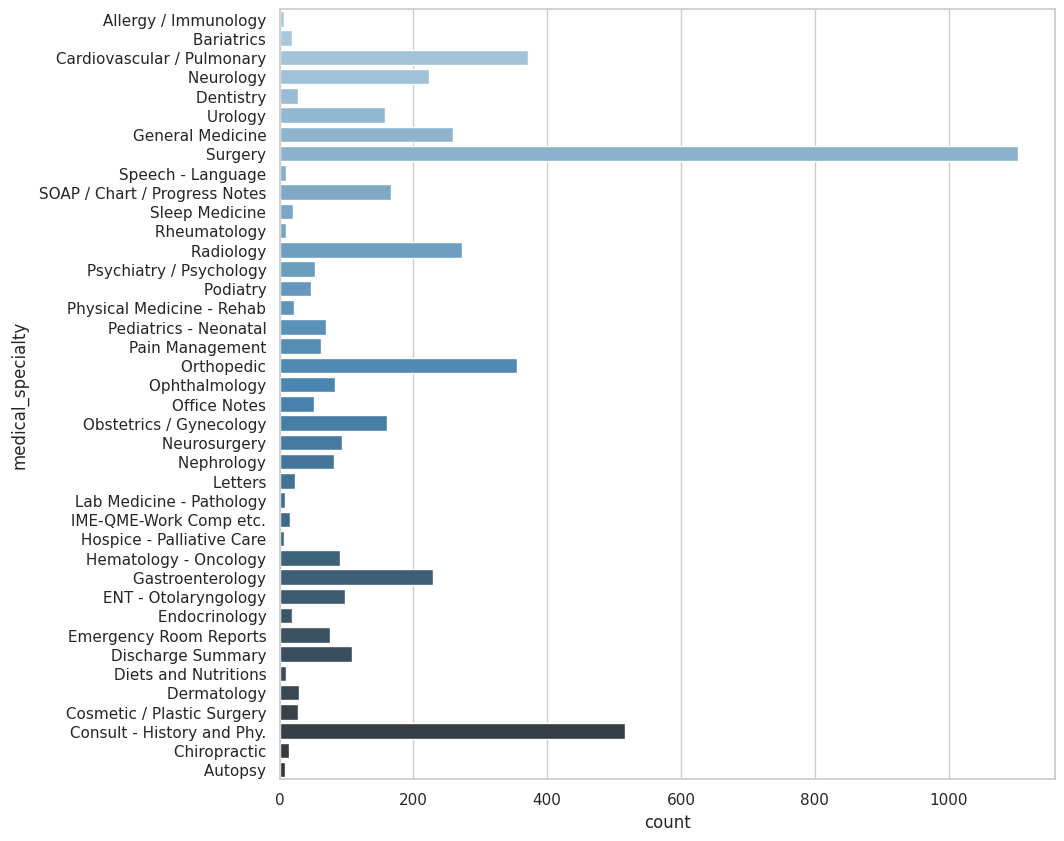

In [4]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# visualize classes (medical spezialities)
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.countplot(y='medical_specialty', data=df, palette="Blues_d")
plt.show()

#Class Imbalance
In the figure above one can see that the data is imbalanced. There are seven classes with more than 200 clinical notes and the other 33 classes have less than 200. This may lead to problems while training the model because the model can underestimate the probability of observing a rare class. 
#ToDO what did we do to avoid the class imbalance?


In [5]:
max_l = 250 #max amount of medical reports per class
medi_spec = list(set(df["medical_specialty"].to_list()))
print("Number of classes:", len(medi_spec))

for i in medi_spec: #iterate over medical specialtities
  medstr = i
  length = len(df.loc[df["medical_specialty"]== medstr])

  if length > max_l: 
    #if number of clinical notes is higher as set number (250), the last reports are dropped
    df1 = df.loc[df["medical_specialty"]==medstr]
    index = length - max_l 
    df1 = df1.drop(df1.index[:index])

    df2 = df.loc[df["medical_specialty"]!=medstr]

    df = pd.concat([df1, df2], ignore_index=True)
    #print(len(df.loc[df["medical_specialty"]==medstr]))

    #shuffle 
    df = df.sample(frac=1, ignore_index=True)

  elif length <= max_l:
    #if number of clinical notes is sammler than max_l, the existing clinical notes are duplicated
    df1 = df.loc[df["medical_specialty"]==medstr]
    index = max_l - length 

    x = round(index / length)
    if x == 0:
      continue
    df2 = pd.concat([df1]*x, ignore_index=True)

    df = pd.concat([df, df2], ignore_index=True)
    #print(len(df.loc[df["medical_specialty"]==medstr]))

    #shuffle
    df = df.sample(frac=1, ignore_index=True)

Number of classes: 40


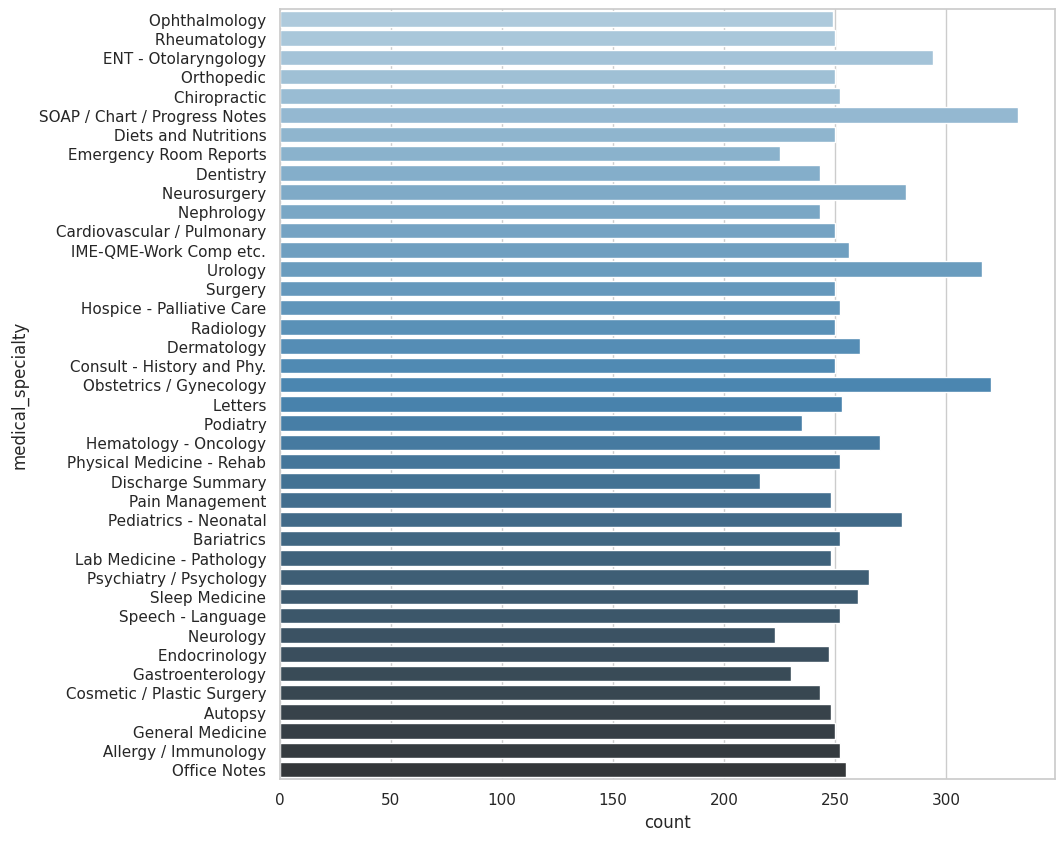

In [6]:
# visualize classes (medical spezialities)
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.countplot(y='medical_specialty', data=df, palette="Blues_d")
plt.show()

In [7]:
df.head()

,medical_specialty,transcription
0,Ophthalmology,"CONJUNCTIVITIS,, better known as Pink Eye, is ..."
1,Rheumatology,"RHEUMATOID ARTHRITIS, (or RA) is a chronic, sy..."
2,ENT - Otolaryngology,Assessment for peripheral vestibular function ...
3,Orthopedic,"PREOPERATIVE DIAGNOSES:, Left calcaneal valgu..."
4,Orthopedic,"PREOPERATIVE DIAGNOSES:,1. Recurrent spinal s..."


#TODO 
One can see that after padding the amount of clinical note there is no class imbalance anymore.

In [ ]:
# visualize most frequent words
word_counts = Counter()

for note in df["transcription"]:
    word_counts += Counter(str(note).split())

# Create a dataframe of word counts
word_counts_df = pd.DataFrame.from_dict(word_counts, orient="index", columns=["count"])
word_counts_df.index.name = "word"
word_counts_df.reset_index(inplace=True)

# Filter the top 35 most frequent words
top_words = word_counts_df.nlargest(35, "count")

# Visualize the top 35 most frequent words using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(data=top_words, y="word", x="count", palette="Blues_d")
plt.title("Top 35 most frequent words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

#2) Preprocessing
To improve our results we will preprocess the data to erease irrelevant information of the clinicla notes. In the first step, we lowercase all words in the transcript and punctutation are removed and replaced by a space. Afterward, all stopwords are removed. Stopwords are words like 'i', 'myself', 'each', 'most' and many more. These words are removed because we can not gain any information from them. In the last step of preprocessing, we lemmatize the data.

In [ ]:
import string
#Clean the data (lowercase, removing all punctuation, etc.)
# remove empty rows
df = df.dropna(subset=['transcription'])

# lowercase all transcripts
df['cleanTranscripts'] = df['transcription'].str.lower().astype(str)

# remove punctuation from the notes and replace them with a space 
df["cleanTranscripts"] = df["cleanTranscripts"].str.replace(r"[{}]".format(string.punctuation), " ")

df.head()

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def unique_words_counter(df):
    # utils function to count unique words in our corpus
    word_counts = Counter()
    for s in df:
        word_counts.update(s.split())
    return word_counts

print(f'There are {len(unique_words_counter(df["cleanTranscripts"]))} unique words in our reports before stop word removal')

# list of stop words
stop_words = stopwords.words('english')
print('stop words:',stop_words)

df['cleanTranscriptsWithoutStopWords'] = df["cleanTranscripts"].apply(lambda text: ' '.join([word for word in text.split() if word not in stop_words]))


print(f'There are {len(unique_words_counter(df["cleanTranscriptsWithoutStopWords"]))} unique words in our reports after stop word removal')

As seen in the output we removed about 130 stopwords from the data set. However most of the unique words were uneffected by the stopword removal as intended.

In [ ]:
# visualize most frequent words again after stop word removal
word_counts = Counter()

for note in df["cleanTranscriptsWithoutStopWords"]:
    word_counts += Counter(str(note).split())


# Create a dataframe of word counts
word_counts_df = pd.DataFrame.from_dict(word_counts, orient="index", columns=["count"])
word_counts_df.index.name = "word"
word_counts_df.reset_index(inplace=True)
#print('word count:',word_counts)

# Filter the top 35 most frequent words
top_words = word_counts_df.nlargest(35, "count")

# Visualize the top 35 most frequent words using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(data=top_words, y="word", x="count", palette="Blues_d")
plt.title("Top 35 most frequent words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

df.head()

In comparison of the earlier figure about the top 35 most frequent words one can see that after removing the stopword the top 35 most frequent words are more relevant and contain more information.

In the next preprocessing step, we lemmatize the data. We decided for lemmatization because lemmatization is an improved version of stemming. Stemming ereases suffixes of words to build the word stem. For example, the words "like", "likely" and "liked" have the word stem "like".
With this preprocessing step a NLP model can learn that these words are similar. In addition to that, lemmatization uses the context of the words as well. For example, the word "better" has "good" as its lemma.
The used Lemmatizer uses a natural language toolkit called WordNet to find the words and their corresponding word stem.

After lemmatization, we tokenized the transcripts. Tokenization extracts the tokens from string of words or sentences. We used the WhitespaceTokenizer which extracts the tokens without whitespaces, new line and tabs. By breaking up the text into small, known fragments, we can apply a model to find a samll set of rules to combine them into some larger meaning. 

In [ ]:
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('wordnet')

# lemmatize words
# import stemmer fromm nltk
lemmatizer = WordNetLemmatizer()

print(f'There are {len(unique_words_counter(df["cleanTranscriptsWithoutStopWords"]))} unique words in our reports before lemmatization')

# use lemmer on the dataset
df["lemmatizedTranscripts"] = [lemmatizer.lemmatize(str(word)) for word in df["cleanTranscriptsWithoutStopWords"]] 

# tokenize data
tokenizer = WhitespaceTokenizer()

# Tokenize the notes using whitespace tokenizer
df["tokenizedTranscripts"] = df["lemmatizedTranscripts"].apply(tokenizer.tokenize)

# count tokens
token_counts = Counter()

for note in df["tokenizedTranscripts"]:
    token_counts += Counter(str(note).split())

# compare word and token counts
print('word count:',word_counts)
print('token count:',token_counts)

df.head()

#TODO Word2Vec - i am not sure where it is used or we could leave it out
why do we use it? what is it?
Notice when constructing the model, I pass in min_count =1 and size = 5. That means it will include all words that occur ≥ one time and generate a vector with a fixed length of five.

In [ ]:
from gensim.models import Word2Vec

corpus = []
corpus = df['tokenizedTranscripts'].to_list()

#show first value
print(corpus[0:1])

#generate vectors from corpus
w2v = Word2Vec(sentences=corpus,vector_size=300,window=10,min_count=1)
print(w2v)

w2v.train(corpus,epochs=10,total_examples=len(corpus))

In [ ]:
# total numberof extracted words
vocab=w2v.wv.index_to_key
print("The total number of words are : ",len(vocab))

In [ ]:
# similaraity b/w two words
w2v.wv.similarity('best','good')

In [ ]:
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=w2v.wv.get_vector(word)
print("The number of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size  

#Divide the dataset into train and test set

Only use X and y_one_hot or y_classes for training purposes in the rest of the notebook. After running the whole notebook, there should be a prediction from your model, which took X_test as input to create the predictions. Each prediction has to be a vector of length 40.

In [ ]:
#read in data into 
_X = df['lemmatizedTranscripts'] #TODO .values wieder hinzufügen??
_y = df['medical_specialty']

In [ ]:
maxi=-1
for i,rev in enumerate(df['tokenizedTranscripts']):
    if(len(rev)>maxi):
        maxi=len(rev)
print(maxi)

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['lemmatizedTranscripts'])
vocab_size = len(tokenizer.word_index) + 1
encd_rev = tokenizer.texts_to_sequences(df['lemmatizedTranscripts'])

Text vectorization is converting text into vectors of values to represent their meanings. 

#TODO: why do we do pad_sequences? how does this function work? advantages?

In [ ]:
#!pip install keras_preprocessing
from keras_preprocessing.sequence import pad_sequences

max_rev_len=1775  # max lenght of a review
vocab_size = len(tokenizer.word_index) + 1  # total no of words
embed_dim=300 # embedding dimension as choosen in word2vec constructor

_X=pad_sequences(encd_rev,padding="post",truncating='post',maxlen=max_rev_len)
_X.shape

In [ ]:
import numpy as np
# now creating the embedding matrix
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tokenizer.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero.

  # checking.
#print(embed_matrix[14])

In [ ]:
from sklearn.model_selection import train_test_split
#one hot encoding of the labels - creates a binary column for each category and returns a dense array
_y_one_hot = pd.get_dummies(_y)

X_train, X_test, y_one_hot, y_one_hot_test = train_test_split(_X, _y_one_hot, test_size=0.2, random_state=123)
_, _, y_classes, _ = train_test_split(_X, _y, test_size=0.2, random_state=123)

print("One hot encoded labels: \n", y_one_hot.values)
print("Shape of X_train and y_train encoded labels:", X_train.shape,y_one_hot.shape)
print("Shape of X_test and y_test:", X_test.shape,y_one_hot_test.shape)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test_model_performance(y_pred,y_test):
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
    print('Recall: ', recall_score(y_test, y_pred, average='weighted'))
    print('F1: ', f1_score(y_test, y_pred, average='weighted'))    

In [ ]:
### performance of a random guesser ###

y_pred_dummy = np.zeros((len(X_test), 40))
# random predictions with sum 1
y_pred_dummy = y_pred_dummy + np.random.rand(y_pred_dummy.shape[0], y_pred_dummy.shape[1])
y_pred_dummy = y_pred_dummy / y_pred_dummy.sum(axis=1).reshape(-1, 1)

# set only highest value to 1 and rest to 0
y_pred_dummy = np.argmax(y_pred_dummy, axis=1)
y_pred_dummy = pd.get_dummies(y_pred_dummy).values

test_model_performance(y_pred_dummy,y_one_hot_test)

#Our Model

#TODO: what did we try?
- Random Forest
- Naive Bayes
- LSTM

how did they work?
why did they not work?
why did we decided for them?

In the end we decided to take a LSTM (Long short-term memory) model. This model....

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input,CuDNNLSTM,LSTM
from keras.models import Model
from keras.preprocessing.text import text_to_word_sequence
from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout
model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_rev_len,embeddings_initializer=Constant(embed_matrix)))
model.add(LSTM(embed_dim, return_sequences=False, stateful=False))
model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(40,activation='relu'))

"""model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_rev_len,embeddings_initializer=Constant(embed_matrix)))
model.add(LSTM(embed_dim, return_sequences=False, stateful=False))
model.add(Dropout(0.2))
model.add(Dense(40,activation='relu'))"""

In [ ]:
model.summary()

In [ ]:
# compile the model
model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-3),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# specify batch size and epocj=hs for training.
epochs=5 #15
batch_size=64

In [ ]:
# fitting the model.
history = model.fit(X_train,y_one_hot,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_one_hot_test))
# for surgery reduced amount of reports: x_test accuracy: 0,13 without LSTM but only one class
# with LSTM: 
#imbalanced but reduced Surgery reports
#     nach 5 epochen: 0,12 - val: 0,13
#     x_test accuracy: 

#class balanced:


In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = np.argmax(y_pred, axis=1)  
y_test = np.argmax(y_one_hot_test.values, axis=1)

test_model_performance(y_pred, y_test)

In [ ]:
from sklearn.metrics import classification_report

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)

# change figsize
plt.figure(figsize=(20, 10))
report_df = pd.DataFrame(report).iloc[:-1, :].T

sns.heatmap(pd.DataFrame(report_df), annot=True)

#TODO: Results
what results did we get?
how do we interpredt them?